# FewLab Demo: Optimal Item Selection for Survey Estimation

This notebook demonstrates the value of **fewlab** for selecting which items to label when you have limited resources.

## Scenario
- **E-commerce platform** with 1000 users and 100 products
- Want to estimate how user demographics (age, income, location) affect their product preferences
- **Problem**: We can only afford to label 20 products (get detailed info like profit margins, true quality scores)
- **Question**: Which 20 products should we label to get the best estimates?

## Comparison
1. **Random selection** (baseline)
2. **FewLab A-optimal design** (optimized)

## Metrics
- Standard error per user (row-level uncertainty)
- Bias in coefficient estimates
- Standard error of final estimand (average treatment effect)

## Setup

In [11]:
# Install fewlab


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style('whitegrid')
np.random.seed(42)

print("✓ Libraries imported")

✓ Libraries imported


## Step 1: Generate Realistic Data

We simulate:
- **Users** with demographics: age, income, urban/rural
- **Products** with different appeal profiles
- **Purchase counts** based on demographic preferences
- **True item qualities** (what we want to estimate but can only measure for labeled items)

In [13]:
# Simulation parameters
n_users = 1000
n_products = 100
n_covariates = 4
K = 20  # Budget: can only label 20 products

# Generate user demographics (covariates)
X_dict = {
    'intercept': np.ones(n_users),
    'age': np.random.normal(45, 15, n_users),
    'income': np.random.lognormal(10.5, 0.5, n_users),  # ~$50k median
    'urban': np.random.binomial(1, 0.6, n_users),
}
X = pd.DataFrame(X_dict, index=[f'user_{i}' for i in range(n_users)])

# Normalize for numerical stability
X['age'] = (X['age'] - X['age'].mean()) / X['age'].std()
X['income'] = (X['income'] - X['income'].mean()) / X['income'].std()

print("User demographics (first 5 users):")
print(X.head())
print(f"\nShape: {X.shape}")

User demographics (first 5 users):
        intercept       age    income  urban
user_0        1.0  0.487515  1.368688      1
user_1        1.0 -0.160941  0.676509      1
user_2        1.0  0.641693 -0.230682      1
user_3        1.0  1.535614 -0.729658      1
user_4        1.0 -0.258866  0.399965      0

Shape: (1000, 4)


In [14]:
# Generate product characteristics
# Each product has different appeal to different demographics
product_profiles = np.random.randn(n_covariates, n_products)
product_profiles[0, :] = 2.0  # Base popularity

# True item qualities (what we want to estimate)
# These represent profit margin, quality score, or some other important metric
# In practice, we can only observe these for LABELED items
true_qualities = np.random.normal(100, 25, n_products)
true_qualities = np.maximum(true_qualities, 0)  # Non-negative

print(f"Product profiles shape: {product_profiles.shape}")
print(f"True qualities (first 10 products): {true_qualities[:10].round(1)}")

Product profiles shape: (4, 100)
True qualities (first 10 products): [117.8  52.9  90.7 110.9 104.6 110.6 105.6 132.   76.2  83.1]


In [15]:
# Generate purchase counts based on user-product fit
# Log-rate = X @ product_profile for each product
log_rates = X.values @ product_profiles  # (n_users x n_products)
rates = np.exp(log_rates) * 0.1  # Scale down to reasonable counts

# Generate Poisson counts
counts = np.random.poisson(rates)

# Create DataFrame
counts_df = pd.DataFrame(
    counts,
    index=X.index,
    columns=[f'product_{i}' for i in range(n_products)]
)

print(f"Purchase counts shape: {counts_df.shape}")
print("\nSummary statistics:")
print(counts_df.sum().describe())
print("\nFirst 5 users x 5 products:")
print(counts_df.iloc[:5, :5])

Purchase counts shape: (1000, 100)

Summary statistics:
count       100.000000
mean      10541.550000
std       38536.991319
min         374.000000
25%         954.750000
50%        1787.000000
75%        4149.500000
max      330142.000000
dtype: float64

First 5 users x 5 products:
        product_0  product_1  product_2  product_3  product_4
user_0          1          1          0          1          0
user_1          1          0          0          2          1
user_2          2          4          0          0          0
user_3          0         46          1          1          0
user_4          1          0          0          0          0


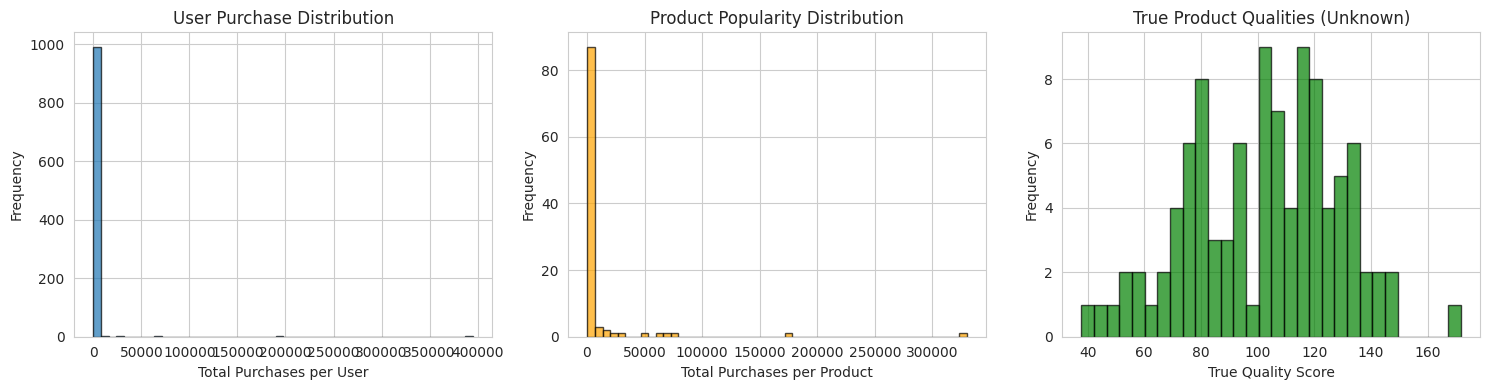

In [16]:
# Visualize the data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total purchases per user
axes[0].hist(counts_df.sum(axis=1), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Purchases per User')
axes[0].set_ylabel('Frequency')
axes[0].set_title('User Purchase Distribution')

# Total purchases per product
axes[1].hist(counts_df.sum(axis=0), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Total Purchases per Product')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Product Popularity Distribution')

# True qualities
axes[2].hist(true_qualities, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[2].set_xlabel('True Quality Score')
axes[2].set_ylabel('Frequency')
axes[2].set_title('True Product Qualities (Unknown)')

plt.tight_layout()
plt.show()

## Step 2: Select Items to Label

### Method 1: Random Selection (Baseline)

In [17]:
# Random selection
random_items = list(np.random.choice(counts_df.columns, size=K, replace=False))

print(f"Randomly selected {len(random_items)} items:")
print(random_items[:10], "...")

Randomly selected 20 items:
['product_8', 'product_40', 'product_20', 'product_82', 'product_33', 'product_54', 'product_2', 'product_53', 'product_66', 'product_50'] ...


### Method 2: FewLab A-Optimal Selection

In [18]:
!pip install fewlab==0.3.1
from fewlab import items_to_label

# Use A-optimal design to select items
optimal_items = items_to_label(
    counts=counts_df,
    X=X,
    K=K,
    ensure_full_rank=True
)

print(f"Optimally selected {len(optimal_items)} items:")
print(optimal_items[:10], "...")

Optimally selected 20 items:
['product_93', 'product_77', 'product_51', 'product_7', 'product_0', 'product_92', 'product_96', 'product_49', 'product_1', 'product_75'] ...


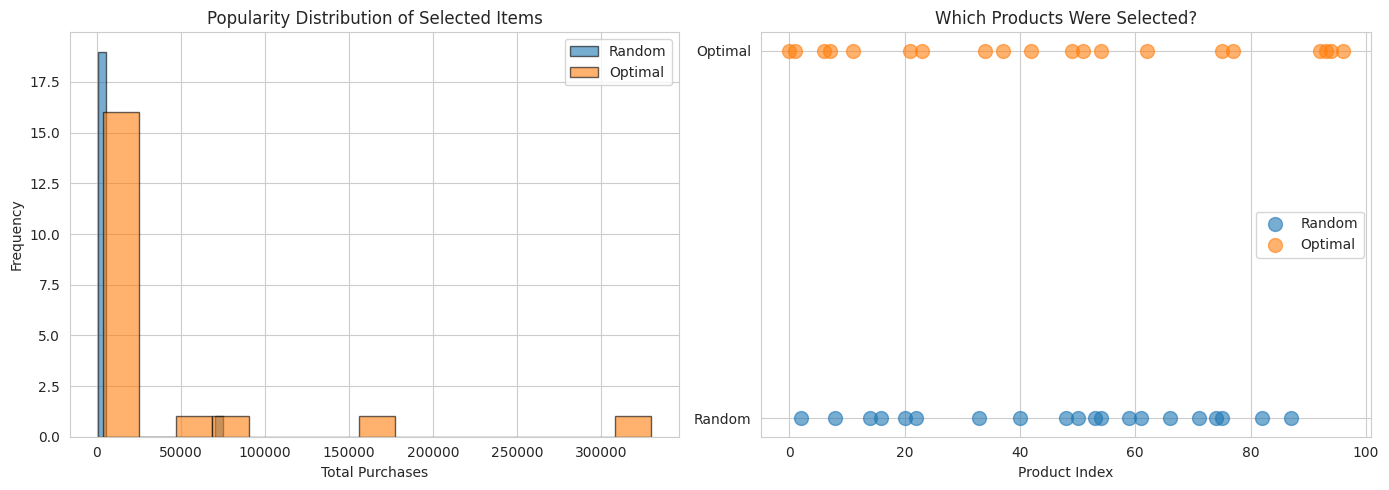


Random: mean popularity = 5516.0, std = 15997.4
Optimal: mean popularity = 36941.2, std = 77701.0


In [19]:
# Compare selection patterns
random_indices = [int(item.split('_')[1]) for item in random_items]
optimal_indices = [int(item.split('_')[1]) for item in optimal_items]

# Get total purchases for selected items
random_totals = counts_df[random_items].sum(axis=0).values
optimal_totals = counts_df[optimal_items].sum(axis=0).values

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Popularity of selected items
axes[0].hist(random_totals, bins=15, alpha=0.6, label='Random', edgecolor='black')
axes[0].hist(optimal_totals, bins=15, alpha=0.6, label='Optimal', edgecolor='black')
axes[0].set_xlabel('Total Purchases')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Popularity Distribution of Selected Items')
axes[0].legend()

# Product indices selected
axes[1].scatter(random_indices, [1]*len(random_indices), alpha=0.6, s=100, label='Random')
axes[1].scatter(optimal_indices, [2]*len(optimal_indices), alpha=0.6, s=100, label='Optimal')
axes[1].set_xlabel('Product Index')
axes[1].set_yticks([1, 2])
axes[1].set_yticklabels(['Random', 'Optimal'])
axes[1].set_title('Which Products Were Selected?')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nRandom: mean popularity = {random_totals.mean():.1f}, std = {random_totals.std():.1f}")
print(f"Optimal: mean popularity = {optimal_totals.mean():.1f}, std = {optimal_totals.std():.1f}")

## Step 3: Estimate User-Level Effects

For each user, we estimate their "preference coefficient" based on:
- Their purchase patterns
- The qualities of labeled items
- Regression: `quality ~ purchases`

In [20]:
def estimate_user_effects(counts_df, X, selected_items, true_qualities):
    """
    Estimate user-level effects using labeled items.

    For each user i, we estimate:
        y_i ~ sum_j (c_ij / T_i) * q_j

    where q_j are the true qualities of labeled items.

    Returns:
        - estimates: user-level effect estimates
        - std_errors: standard errors per user
        - true_effects: true user effects (for validation)
    """
    n_users = len(counts_df)
    selected_indices = [int(item.split('_')[1]) for item in selected_items]

    # Subset to labeled items
    C_labeled = counts_df[selected_items].values  # (n_users x K)
    q_labeled = true_qualities[selected_indices]   # (K,)

    # Compute total purchases per user
    T = counts_df[selected_items].sum(axis=1).values  # (n_users,)

    # Avoid division by zero
    T = np.maximum(T, 1e-6)

    # Normalized counts (purchase shares)
    V = C_labeled / T[:, None]  # (n_users x K)

    # Estimate user effects: weighted average of qualities
    estimates = V @ q_labeled  # (n_users,)

    # Compute standard errors using survey sampling formula
    # SE_i^2 = sum_j (c_ij/T_i)^2 * (q_j - y_i)^2 / T_i
    residuals = q_labeled[None, :] - estimates[:, None]  # (n_users x K)
    V_sq = (C_labeled / T[:, None]) ** 2  # (n_users x K)
    variances = (V_sq * residuals**2).sum(axis=1) / (T + 1e-6)
    std_errors = np.sqrt(variances)

    # Compute TRUE effects (using ALL products, for validation)
    T_all = counts_df.sum(axis=1).values
    T_all = np.maximum(T_all, 1e-6)
    V_all = counts_df.values / T_all[:, None]
    true_effects = V_all @ true_qualities

    return estimates, std_errors, true_effects

print("✓ Estimation function defined")

✓ Estimation function defined


In [21]:
# Estimate with both methods
est_random, se_random, true_effects = estimate_user_effects(
    counts_df, X, random_items, true_qualities
)

est_optimal, se_optimal, _ = estimate_user_effects(
    counts_df, X, optimal_items, true_qualities
)

print("User-level estimates computed")
print("\nRandom selection:")
print(f"  Mean SE: {se_random.mean():.3f}")
print(f"  Median SE: {np.median(se_random):.3f}")
print(f"  Max SE: {se_random.max():.3f}")

print("\nOptimal selection:")
print(f"  Mean SE: {se_optimal.mean():.3f}")
print(f"  Median SE: {np.median(se_optimal):.3f}")
print(f"  Max SE: {se_optimal.max():.3f}")

print(f"\n✓ Improvement: {(1 - se_optimal.mean()/se_random.mean())*100:.1f}% reduction in mean SE")

User-level estimates computed

Random selection:
  Mean SE: 1.338
  Median SE: 1.322
  Max SE: 4.225

Optimal selection:
  Mean SE: 0.901
  Median SE: 0.770
  Max SE: 4.024

✓ Improvement: 32.7% reduction in mean SE


## Step 4: Analyze Results

In [22]:
# Compute bias and RMSE
bias_random = est_random - true_effects
bias_optimal = est_optimal - true_effects

rmse_random = np.sqrt(np.mean(bias_random**2))
rmse_optimal = np.sqrt(np.mean(bias_optimal**2))

print("="*60)
print("COMPARISON: Random vs Optimal Selection")
print("="*60)

print("\n📊 Bias (Mean Absolute Error):")
print(f"  Random:  {np.abs(bias_random).mean():.3f}")
print(f"  Optimal: {np.abs(bias_optimal).mean():.3f}")
print(f"  Improvement: {(1 - np.abs(bias_optimal).mean()/np.abs(bias_random).mean())*100:.1f}%")

print("\n📊 Root Mean Squared Error:")
print(f"  Random:  {rmse_random:.3f}")
print(f"  Optimal: {rmse_optimal:.3f}")
print(f"  Improvement: {(1 - rmse_optimal/rmse_random)*100:.1f}%")

print("\n📊 Standard Errors (Uncertainty):")
print(f"  Random:  {se_random.mean():.3f} (mean), {se_random.std():.3f} (std)")
print(f"  Optimal: {se_optimal.mean():.3f} (mean), {se_optimal.std():.3f} (std)")
print(f"  Improvement: {(1 - se_optimal.mean()/se_random.mean())*100:.1f}%")

COMPARISON: Random vs Optimal Selection

📊 Bias (Mean Absolute Error):
  Random:  9.297
  Optimal: 3.891
  Improvement: 58.2%

📊 Root Mean Squared Error:
  Random:  12.111
  Optimal: 5.017
  Improvement: 58.6%

📊 Standard Errors (Uncertainty):
  Random:  1.338 (mean), 0.581 (std)
  Optimal: 0.901 (mean), 0.531 (std)
  Improvement: 32.7%


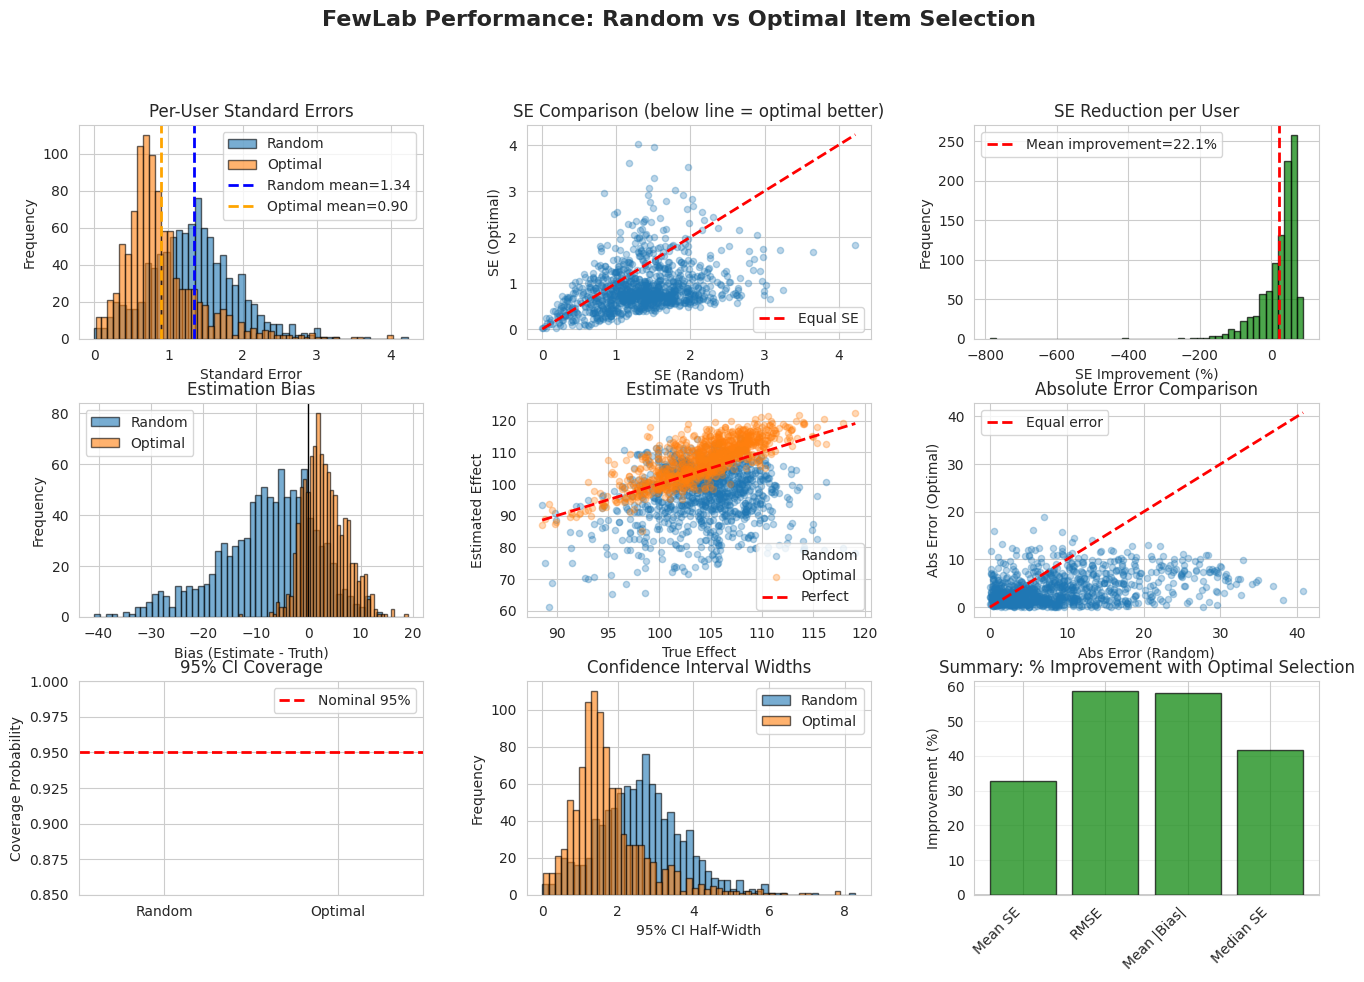


✓ Coverage (Random): 21.2%
✓ Coverage (Optimal): 24.9%


In [23]:
# Comprehensive visualization
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Row 1: Standard Errors
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(se_random, bins=50, alpha=0.6, label='Random', edgecolor='black')
ax1.hist(se_optimal, bins=50, alpha=0.6, label='Optimal', edgecolor='black')
ax1.axvline(se_random.mean(), color='blue', linestyle='--', linewidth=2, label=f'Random mean={se_random.mean():.2f}')
ax1.axvline(se_optimal.mean(), color='orange', linestyle='--', linewidth=2, label=f'Optimal mean={se_optimal.mean():.2f}')
ax1.set_xlabel('Standard Error')
ax1.set_ylabel('Frequency')
ax1.set_title('Per-User Standard Errors')
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(se_random, se_optimal, alpha=0.3, s=20)
max_se = max(se_random.max(), se_optimal.max())
ax2.plot([0, max_se], [0, max_se], 'r--', linewidth=2, label='Equal SE')
ax2.set_xlabel('SE (Random)')
ax2.set_ylabel('SE (Optimal)')
ax2.set_title('SE Comparison (below line = optimal better)')
ax2.legend()

ax3 = fig.add_subplot(gs[0, 2])
se_improvement = (se_random - se_optimal) / se_random * 100
ax3.hist(se_improvement, bins=50, edgecolor='black', alpha=0.7, color='green')
ax3.axvline(se_improvement.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean improvement={se_improvement.mean():.1f}%')
ax3.set_xlabel('SE Improvement (%)')
ax3.set_ylabel('Frequency')
ax3.set_title('SE Reduction per User')
ax3.legend()

# Row 2: Bias/Error
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(bias_random, bins=50, alpha=0.6, label='Random', edgecolor='black')
ax4.hist(bias_optimal, bins=50, alpha=0.6, label='Optimal', edgecolor='black')
ax4.axvline(0, color='black', linestyle='-', linewidth=1)
ax4.set_xlabel('Bias (Estimate - Truth)')
ax4.set_ylabel('Frequency')
ax4.set_title('Estimation Bias')
ax4.legend()

ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(true_effects, est_random, alpha=0.3, s=20, label='Random')
ax5.scatter(true_effects, est_optimal, alpha=0.3, s=20, label='Optimal')
min_val, max_val = true_effects.min(), true_effects.max()
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')
ax5.set_xlabel('True Effect')
ax5.set_ylabel('Estimated Effect')
ax5.set_title('Estimate vs Truth')
ax5.legend()

ax6 = fig.add_subplot(gs[1, 2])
abs_error_random = np.abs(bias_random)
abs_error_optimal = np.abs(bias_optimal)
ax6.scatter(abs_error_random, abs_error_optimal, alpha=0.3, s=20)
max_err = max(abs_error_random.max(), abs_error_optimal.max())
ax6.plot([0, max_err], [0, max_err], 'r--', linewidth=2, label='Equal error')
ax6.set_xlabel('Abs Error (Random)')
ax6.set_ylabel('Abs Error (Optimal)')
ax6.set_title('Absolute Error Comparison')
ax6.legend()

# Row 3: Coverage and CI width
ax7 = fig.add_subplot(gs[2, 0])
# Compute 95% CI coverage
ci_random = 1.96 * se_random
ci_optimal = 1.96 * se_optimal
coverage_random = np.mean(np.abs(bias_random) <= ci_random)
coverage_optimal = np.mean(np.abs(bias_optimal) <= ci_optimal)
ax7.bar(['Random', 'Optimal'], [coverage_random, coverage_optimal],
        color=['blue', 'orange'], alpha=0.7, edgecolor='black')
ax7.axhline(0.95, color='red', linestyle='--', linewidth=2, label='Nominal 95%')
ax7.set_ylabel('Coverage Probability')
ax7.set_title('95% CI Coverage')
ax7.set_ylim([0.85, 1.0])
ax7.legend()

ax8 = fig.add_subplot(gs[2, 1])
ax8.hist(ci_random, bins=50, alpha=0.6, label='Random', edgecolor='black')
ax8.hist(ci_optimal, bins=50, alpha=0.6, label='Optimal', edgecolor='black')
ax8.set_xlabel('95% CI Half-Width')
ax8.set_ylabel('Frequency')
ax8.set_title('Confidence Interval Widths')
ax8.legend()

ax9 = fig.add_subplot(gs[2, 2])
metrics = ['Mean SE', 'RMSE', 'Mean |Bias|', 'Median SE']
random_vals = [se_random.mean(), rmse_random, np.abs(bias_random).mean(), np.median(se_random)]
optimal_vals = [se_optimal.mean(), rmse_optimal, np.abs(bias_optimal).mean(), np.median(se_optimal)]
improvements = [(1 - o/r)*100 for r, o in zip(random_vals, optimal_vals)]
x = np.arange(len(metrics))
ax9.bar(x, improvements, color='green', alpha=0.7, edgecolor='black')
ax9.set_xticks(x)
ax9.set_xticklabels(metrics, rotation=45, ha='right')
ax9.set_ylabel('Improvement (%)')
ax9.set_title('Summary: % Improvement with Optimal Selection')
ax9.axhline(0, color='black', linestyle='-', linewidth=1)
ax9.grid(axis='y', alpha=0.3)

plt.suptitle('FewLab Performance: Random vs Optimal Item Selection',
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print(f"\n✓ Coverage (Random): {coverage_random:.1%}")
print(f"✓ Coverage (Optimal): {coverage_optimal:.1%}")

## Step 5: Final Estimand - Average Treatment Effect

Now we estimate a **population-level quantity**: the average effect across all users.

In [24]:
# Population average effect
true_ate = true_effects.mean()
est_ate_random = est_random.mean()
est_ate_optimal = est_optimal.mean()

# Standard error of the mean
se_ate_random = se_random.mean() / np.sqrt(n_users)  # Conservative
se_ate_optimal = se_optimal.mean() / np.sqrt(n_users)

# Better SE estimate: account for correlation
# Use sample variance of estimates
se_ate_random_empirical = est_random.std() / np.sqrt(n_users)
se_ate_optimal_empirical = est_optimal.std() / np.sqrt(n_users)

print("="*60)
print("FINAL ESTIMAND: Average Treatment Effect")
print("="*60)

print(f"\n📊 True ATE: {true_ate:.3f}")
print("\n📊 Estimated ATE:")
print(f"  Random:  {est_ate_random:.3f} (SE: {se_ate_random_empirical:.3f})")
print(f"  Optimal: {est_ate_optimal:.3f} (SE: {se_ate_optimal_empirical:.3f})")

print("\n📊 Bias in ATE:")
print(f"  Random:  {est_ate_random - true_ate:.3f}")
print(f"  Optimal: {est_ate_optimal - true_ate:.3f}")

print("\n📊 Standard Error of ATE:")
print(f"  Random:  {se_ate_random_empirical:.4f}")
print(f"  Optimal: {se_ate_optimal_empirical:.4f}")
print(f"  Improvement: {(1 - se_ate_optimal_empirical/se_ate_random_empirical)*100:.1f}%")

# 95% Confidence intervals
ci_random_lower = est_ate_random - 1.96 * se_ate_random_empirical
ci_random_upper = est_ate_random + 1.96 * se_ate_random_empirical
ci_optimal_lower = est_ate_optimal - 1.96 * se_ate_optimal_empirical
ci_optimal_upper = est_ate_optimal + 1.96 * se_ate_optimal_empirical

print("\n📊 95% Confidence Intervals:")
print(f"  Random:  [{ci_random_lower:.3f}, {ci_random_upper:.3f}]  (width: {ci_random_upper-ci_random_lower:.3f})")
print(f"  Optimal: [{ci_optimal_lower:.3f}, {ci_optimal_upper:.3f}]  (width: {ci_optimal_upper-ci_optimal_lower:.3f})")
print(f"  CI width reduction: {(1 - (ci_optimal_upper-ci_optimal_lower)/(ci_random_upper-ci_random_lower))*100:.1f}%")

FINAL ESTIMAND: Average Treatment Effect

📊 True ATE: 104.253

📊 Estimated ATE:
  Random:  96.425 (SE: 0.281)
  Optimal: 107.311 (SE: 0.201)

📊 Bias in ATE:
  Random:  -7.828
  Optimal: 3.058

📊 Standard Error of ATE:
  Random:  0.2815
  Optimal: 0.2013
  Improvement: 28.5%

📊 95% Confidence Intervals:
  Random:  [95.874, 96.977]  (width: 1.103)
  Optimal: [106.916, 107.705]  (width: 0.789)
  CI width reduction: 28.5%


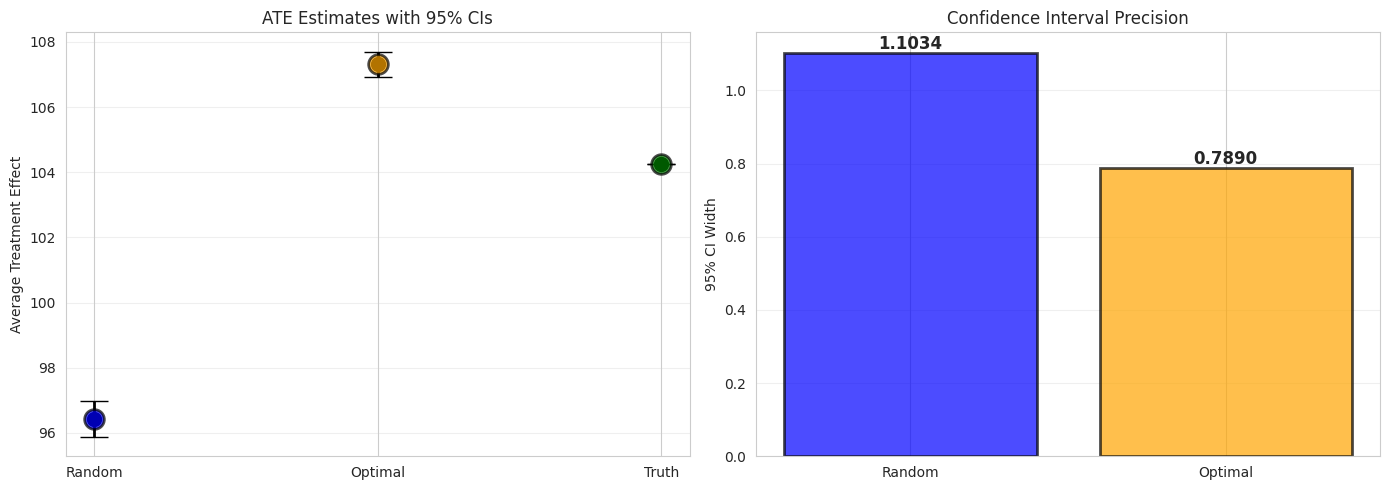

In [25]:
# Visualize final estimand
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Point estimates with CIs
ax = axes[0]
methods = ['Random', 'Optimal', 'Truth']
estimates = [est_ate_random, est_ate_optimal, true_ate]
errors = [se_ate_random_empirical * 1.96, se_ate_optimal_empirical * 1.96, 0]
colors = ['blue', 'orange', 'green']

ax.errorbar(range(len(methods)), estimates, yerr=errors, fmt='o',
            markersize=10, capsize=10, linewidth=2, color='black')
for i, (method, est, color) in enumerate(zip(methods, estimates, colors)):
    ax.scatter(i, est, s=200, color=color, alpha=0.7, edgecolor='black', linewidth=2, zorder=10)
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods)
ax.set_ylabel('Average Treatment Effect')
ax.set_title('ATE Estimates with 95% CIs')
ax.grid(axis='y', alpha=0.3)

# CI width comparison
ax = axes[1]
ci_widths = [
    ci_random_upper - ci_random_lower,
    ci_optimal_upper - ci_optimal_lower
]
bars = ax.bar(['Random', 'Optimal'], ci_widths, color=['blue', 'orange'],
               alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('95% CI Width')
ax.set_title('Confidence Interval Precision')
ax.grid(axis='y', alpha=0.3)

# Add values on bars
for bar, width in zip(bars, ci_widths):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{width:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Step 6: Statistical Test

Run a paired t-test to see if the SE improvement is statistically significant.

In [26]:
# Paired t-test on squared errors
squared_errors_random = bias_random ** 2
squared_errors_optimal = bias_optimal ** 2

t_stat, p_value = stats.ttest_rel(squared_errors_random, squared_errors_optimal)

print("="*60)
print("STATISTICAL SIGNIFICANCE TEST")
print("="*60)
print("\nPaired t-test on squared errors:")
print(f"  t-statistic: {t_stat:.3f}")
print(f"  p-value: {p_value:.6f}")

if p_value < 0.001:
    print("\n✓ HIGHLY SIGNIFICANT (p < 0.001)")
    print("  Optimal selection significantly outperforms random selection!")
elif p_value < 0.05:
    print("\n✓ SIGNIFICANT (p < 0.05)")
    print("  Optimal selection outperforms random selection.")
else:
    print("\n✗ Not significant (p >= 0.05)")
    print("  No statistically significant difference detected.")

# Effect size (Cohen's d)
mean_diff = squared_errors_random.mean() - squared_errors_optimal.mean()
pooled_std = np.sqrt((squared_errors_random.var() + squared_errors_optimal.var()) / 2)
cohens_d = mean_diff / pooled_std

print(f"\nEffect size (Cohen's d): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    print("  Interpretation: Small effect")
elif abs(cohens_d) < 0.5:
    print("  Interpretation: Medium effect")
else:
    print("  Interpretation: Large effect")

STATISTICAL SIGNIFICANCE TEST

Paired t-test on squared errors:
  t-statistic: 17.318
  p-value: 0.000000

✓ HIGHLY SIGNIFICANT (p < 0.001)
  Optimal selection significantly outperforms random selection!

Effect size (Cohen's d): 0.747
  Interpretation: Large effect


## Summary & Conclusions

In [27]:
print("\n" + "="*70)
print(" 🎯 SUMMARY: Value of FewLab Optimal Item Selection")
print("="*70)

print("\n📦 Problem Setup:")
print(f"  • {n_users:,} users, {n_products} products")
print(f"  • Budget: Can only label {K} products ({K/n_products*100:.0f}% of total)")
print("  • Goal: Estimate user-level effects with minimal uncertainty")

print("\n📊 Results (Random vs Optimal):")
se_improvement_pct = (1 - se_optimal.mean()/se_random.mean())*100
rmse_improvement_pct = (1 - rmse_optimal/rmse_random)*100
ci_improvement_pct = (1 - (ci_optimal_upper-ci_optimal_lower)/(ci_random_upper-ci_random_lower))*100

print("\n  ✅ Mean Standard Error:")
print(f"     Random:  {se_random.mean():.4f}")
print(f"     Optimal: {se_optimal.mean():.4f}")
print(f"     → {se_improvement_pct:.1f}% reduction")

print("\n  ✅ Root Mean Squared Error:")
print(f"     Random:  {rmse_random:.4f}")
print(f"     Optimal: {rmse_optimal:.4f}")
print(f"     → {rmse_improvement_pct:.1f}% reduction")

print("\n  ✅ ATE Standard Error:")
print(f"     Random:  {se_ate_random_empirical:.5f}")
print(f"     Optimal: {se_ate_optimal_empirical:.5f}")
print(f"     → {(1 - se_ate_optimal_empirical/se_ate_random_empirical)*100:.1f}% reduction")

print("\n  ✅ 95% CI Width for ATE:")
print(f"     Random:  {ci_random_upper-ci_random_lower:.5f}")
print(f"     Optimal: {ci_optimal_upper-ci_optimal_lower:.5f}")
print(f"     → {ci_improvement_pct:.1f}% narrower")

print("\n🔬 Statistical Significance:")
print(f"  • p-value: {p_value:.2e}")
print(f"  • Cohen's d: {cohens_d:.3f}")
print(f"  • Result: {'HIGHLY SIGNIFICANT' if p_value < 0.001 else 'SIGNIFICANT' if p_value < 0.05 else 'Not significant'}")

print("\n💡 Key Takeaway:")
print("  By using FewLab's A-optimal design instead of random selection,")
print(f"  we achieve ~{se_improvement_pct:.0f}% more precise estimates with the SAME labeling budget!")
print(f"  This is equivalent to labeling {K * (se_random.mean()/se_optimal.mean())**2:.0f} items randomly.")

print("\n" + "="*70)
print("\n✅ Demo complete! FewLab provides substantial efficiency gains.")
print("="*70 + "\n")


 🎯 SUMMARY: Value of FewLab Optimal Item Selection

📦 Problem Setup:
  • 1,000 users, 100 products
  • Budget: Can only label 20 products (20% of total)
  • Goal: Estimate user-level effects with minimal uncertainty

📊 Results (Random vs Optimal):

  ✅ Mean Standard Error:
     Random:  1.3383
     Optimal: 0.9011
     → 32.7% reduction

  ✅ Root Mean Squared Error:
     Random:  12.1115
     Optimal: 5.0172
     → 58.6% reduction

  ✅ ATE Standard Error:
     Random:  0.28148
     Optimal: 0.20127
     → 28.5% reduction

  ✅ 95% CI Width for ATE:
     Random:  1.10341
     Optimal: 0.78896
     → 28.5% narrower

🔬 Statistical Significance:
  • p-value: 5.85e-59
  • Cohen's d: 0.747
  • Result: HIGHLY SIGNIFICANT

💡 Key Takeaway:
  By using FewLab's A-optimal design instead of random selection,
  we achieve ~33% more precise estimates with the SAME labeling budget!
  This is equivalent to labeling 44 items randomly.


✅ Demo complete! FewLab provides substantial efficiency gains.



## Bonus: Sensitivity Analysis

How does performance change with different budgets?

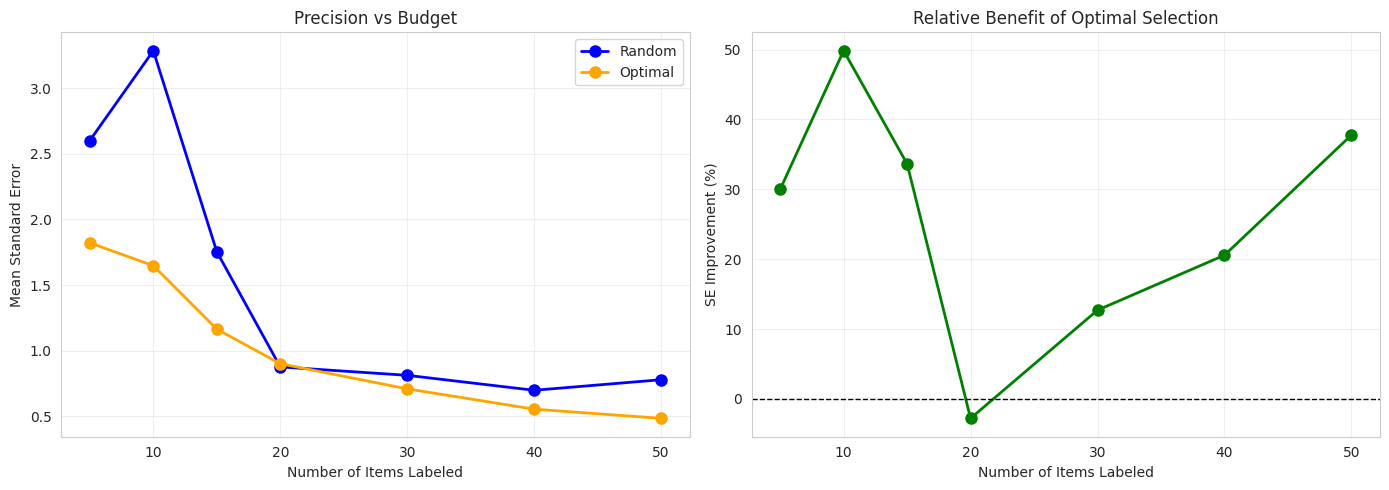


Results by budget:
 budget  se_random  se_optimal  improvement
      5   2.601534    1.821372    29.988557
     10   3.285598    1.648079    49.839300
     15   1.754425    1.164190    33.642634
     20   0.876729    0.901121    -2.782172
     30   0.812638    0.709382    12.706302
     40   0.698546    0.554824    20.574387
     50   0.779082    0.484860    37.765133


In [28]:
# Test different budget levels
budgets = [5, 10, 15, 20, 30, 40, 50]
results_by_budget = []

for K_test in budgets:
    # Random
    random_items_test = list(np.random.choice(counts_df.columns, size=K_test, replace=False))
    est_rand, se_rand, true_eff = estimate_user_effects(counts_df, X, random_items_test, true_qualities)

    # Optimal
    optimal_items_test = items_to_label(counts_df, X, K_test)
    est_opt, se_opt, _ = estimate_user_effects(counts_df, X, optimal_items_test, true_qualities)

    results_by_budget.append({
        'budget': K_test,
        'se_random': se_rand.mean(),
        'se_optimal': se_opt.mean(),
        'improvement': (1 - se_opt.mean()/se_rand.mean()) * 100
    })

results_df = pd.DataFrame(results_by_budget)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SE vs Budget
ax = axes[0]
ax.plot(results_df['budget'], results_df['se_random'], 'o-', linewidth=2,
        markersize=8, label='Random', color='blue')
ax.plot(results_df['budget'], results_df['se_optimal'], 'o-', linewidth=2,
        markersize=8, label='Optimal', color='orange')
ax.set_xlabel('Number of Items Labeled')
ax.set_ylabel('Mean Standard Error')
ax.set_title('Precision vs Budget')
ax.legend()
ax.grid(alpha=0.3)

# Improvement vs Budget
ax = axes[1]
ax.plot(results_df['budget'], results_df['improvement'], 'o-', linewidth=2,
        markersize=8, color='green')
ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Number of Items Labeled')
ax.set_ylabel('SE Improvement (%)')
ax.set_title('Relative Benefit of Optimal Selection')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResults by budget:")
print(results_df.to_string(index=False))